## Importing the required libraries

In [91]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [92]:
from keras import regularizers

In [93]:
import os

In [94]:
mylist= os.listdir('RawData/')

In [95]:
type(mylist)

list

In [96]:
print(mylist[1800])

03-01-02-01-02-02-03.wav


In [97]:
print(mylist[1800][6:-16])

02


## Plotting the audio file's waveform and its spectrogram

In [98]:
data, sampling_rate = librosa.load('RawData/f11 (2).wav')

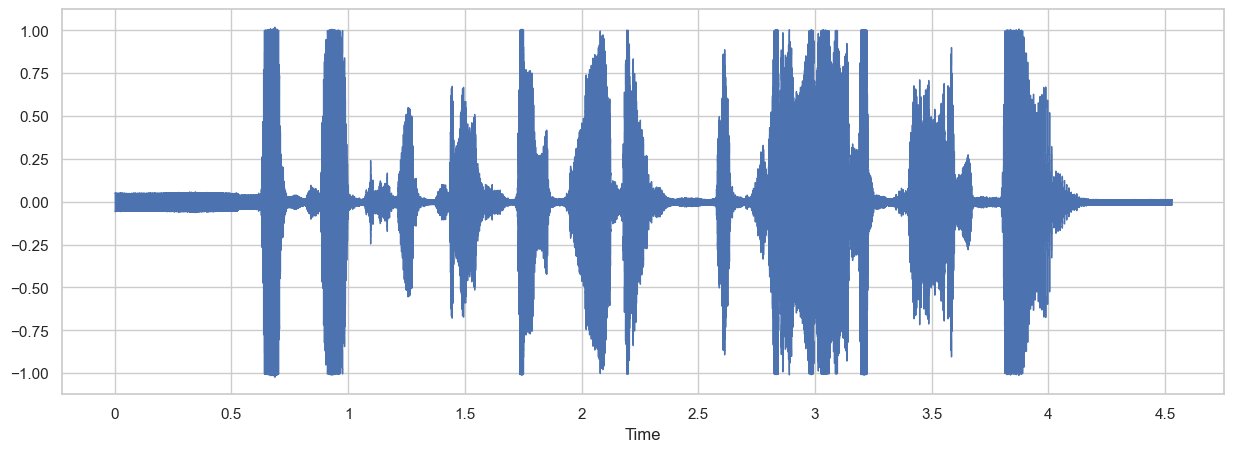

In [99]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

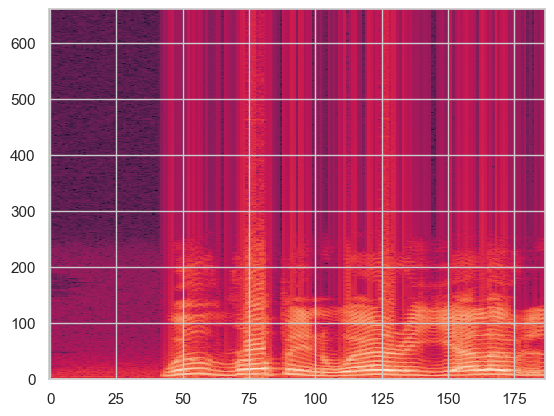

In [100]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [101]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [102]:
labels = pd.DataFrame(feeling_list)

In [103]:
labels[:10]

,0
0,female_fearful
1,female_angry
2,female_happy
3,male_happy
4,female_happy
5,male_happy
6,female_fearful
7,female_angry
8,female_calm
9,female_sad


## Getting the features of audio files using librosa

In [104]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
mylist = [f for f in mylist if not f.endswith('.DS_Store')]
for index,y in enumerate(mylist):
    if not y.lower().endswith(('.wav', '.mp3')):
        continue
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [105]:
df[:5]

,feature
0,"[-56.018803, -55.571507, -56.93122, -56.681602..."
1,"[-55.074707, -55.074707, -55.074707, -55.07470..."
2,"[-55.80937, -55.411068, -55.242924, -54.338154..."
3,"[-18.576942, -22.158924, -28.685892, -28.02898..."
4,"[-50.72093, -47.694363, -47.40706, -48.72259, ..."


In [106]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [107]:
newdf = pd.concat([df3,labels], axis=1)

In [108]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [109]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-56.018803,-55.571507,-56.931221,-56.681602,-56.784340,-55.854233,-55.723244,-56.154278,-55.498997,-53.932571,...,-57.985317,-58.165974,-58.036106,-55.960670,-56.344917,-57.952072,-54.570786,-51.331070,-52.514744,female_fearful
1,-55.074707,-55.074707,-55.074707,-55.074707,-55.074707,-55.074707,-55.074707,-55.074707,-55.074707,-55.074707,...,-36.851357,-37.446266,-39.283459,-40.322411,-39.818974,-40.866398,-40.480370,-42.019131,-44.369179,female_angry
2,-55.809368,-55.411068,-55.242924,-54.338154,-51.846134,-50.901180,-51.864582,-53.123650,-51.652481,-52.188503,...,-36.268398,-37.338688,-36.981384,-36.189865,-38.255062,-42.114395,-41.544956,-23.907696,-14.447266,female_happy
3,-18.576942,-22.158924,-28.685892,-28.028982,-30.085142,-31.538404,-30.330540,-32.387249,-31.970201,-30.251207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_happy
4,-50.720928,-47.694363,-47.407059,-48.722591,-50.155910,-49.914307,-50.302773,-49.821011,-48.415573,-47.448429,...,-41.046394,-40.217445,-41.339436,-40.097435,-41.549980,-40.854042,-41.652805,-36.015892,-27.500872,female_happy


In [110]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
542,-63.919388,-63.919388,-63.919388,-63.919388,-63.919388,-63.919388,-63.919388,-63.919388,-63.919388,-63.919388,...,-48.048386,-47.247929,-48.581852,-49.657536,-51.463684,-51.951458,-50.135288,-50.511959,-53.112820,female_calm
466,-42.706303,-43.410870,-44.025356,-43.548836,-43.634338,-44.423447,-45.022175,-45.497185,-46.613838,-46.140072,...,-19.447874,-20.744652,-18.948275,-18.834820,-20.838940,-24.167683,-26.303576,-19.319151,-14.799470,male_angry
1426,-57.615868,-57.615868,-57.615868,-57.689796,-57.808208,-57.896416,-58.049889,-57.969578,-56.432102,-55.733902,...,-41.849697,-43.112617,-43.041973,-45.124447,-45.466125,-45.051060,-47.239738,-47.926498,-50.467709,female_angry
1324,-56.292900,-56.292900,-56.292900,-55.461952,-55.273827,-56.292900,-56.292900,-55.830563,-56.197823,-56.292900,...,-21.840322,-22.586637,-23.470304,-24.700848,-25.325397,-25.497898,-26.085602,-21.334011,-16.582218,male_sad
1140,-58.267002,-58.411404,-58.909786,-58.984818,-58.474159,-58.049091,-55.456585,-56.027561,-56.193295,-56.783123,...,-40.496056,-40.538597,-42.797523,-39.979771,-39.302689,-39.470486,-41.332039,-32.240566,-25.220846,female_calm
351,-44.178360,-42.783512,-45.965523,-48.939491,-46.545166,-46.378391,-47.518574,-47.010338,-47.029476,-45.875690,...,-36.501236,-33.501297,-33.122158,-35.348965,-34.730583,-34.234585,-34.152050,-24.932140,-16.463417,male_happy
267,-49.808743,-49.068810,-47.859863,-47.570702,-46.955868,-46.456863,-46.171120,-46.812313,-47.934731,-48.422482,...,-39.253353,-38.579784,-40.636082,-41.736366,-40.628315,-40.315186,-38.640205,-27.239742,-18.578085,female_sad
62,-59.926273,-59.926273,-59.926273,-59.926273,-59.926273,-59.926273,-59.120029,-58.407097,-57.869633,-57.496456,...,-35.784817,-37.684719,-28.495665,-25.226280,-28.214027,-32.693943,-31.741396,-29.515381,-24.216240,male_sad
482,-48.477303,-49.269390,-49.493034,-47.290001,-47.123909,-47.787308,-48.788303,-48.045872,-48.440403,-49.792542,...,-17.942039,-17.441656,-19.876497,-20.236107,-19.674694,-19.875164,-22.501543,-16.671602,-10.938514,male_angry
273,-63.232765,-63.022537,-63.541489,-62.890537,-62.745628,-62.968357,-63.459084,-62.623543,-63.306301,-63.139694,...,-60.802467,-60.001240,-61.618118,-62.018845,-61.559689,-62.194077,-62.659569,-62.687820,-63.012966,female_fearful


In [111]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [112]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [113]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1971,-52.135635,-50.993507,-52.111824,-53.816223,-50.711712,-49.508072,-50.742657,-51.723667,-51.633396,-52.001263,...,-38.566101,-39.543663,-39.507980,-39.207260,-38.964947,-40.820034,-41.820045,-43.116684,-40.276939,female_fearful
1977,-50.324631,-47.099712,-46.178219,-48.906540,-49.008892,-46.791763,-46.070904,-49.244804,-49.854084,-48.207420,...,-33.916756,-34.232124,-36.540993,-37.225910,-36.283936,-37.516602,-38.179085,-39.819904,-41.910027,female_angry
1258,-55.771282,-55.683834,-56.035526,-56.232395,-56.268875,-56.117867,-55.991581,-55.988937,-55.998520,-55.998520,...,-43.849358,-43.504692,-43.790775,-44.618916,-43.397488,-42.753239,-41.638443,-29.154459,-21.605604,female_fearful
7,-58.939995,-58.939995,-58.939995,-58.939995,-58.939995,-58.939995,-58.939995,-58.939995,-58.939995,-58.939995,...,-46.350723,-47.066635,-48.931763,-47.600994,-49.094681,-50.973598,-51.739628,-49.989487,-49.665195,female_angry
1522,-66.348564,-66.348564,-66.348564,-66.348564,-66.348564,-62.797642,-65.721535,-66.348564,-66.348564,-66.348564,...,-52.630859,-49.383850,-49.429741,-52.420185,-53.661373,-53.483269,-52.205986,-53.969204,-55.890995,male_sad
536,4.396011,0.603022,-13.473421,-16.501427,-18.999697,-18.462029,-20.613871,-19.705137,-17.468533,-14.508604,...,-0.651737,-0.665746,0.557131,0.633497,-0.656331,-0.114810,-0.092396,1.436762,3.803276,male_happy
2073,-26.496824,-28.835320,-33.991604,-34.408749,-36.503506,-38.438156,-39.560059,-38.825672,-39.542648,-38.212303,...,-17.302563,-16.982449,-18.684986,-19.081408,-18.516832,-18.047577,-19.321791,-16.380253,-10.277598,male_fearful
228,-52.960838,-52.960838,-52.960838,-52.960838,-52.960838,-52.960838,-52.960838,-52.960838,-52.960838,-52.960838,...,-39.159096,-38.962620,-36.478874,-37.951710,-42.900314,-41.615459,-42.586143,-39.223515,-32.620586,female_angry
1183,5.249550,1.067111,-7.510030,-8.219572,-9.414698,-9.160905,-11.020782,-12.668964,-8.848495,-5.399279,...,-5.680862,-5.719815,-5.779328,-5.962616,-5.582254,-5.695951,-6.153378,-5.423775,-4.735022,male_angry
950,-50.154522,-47.490356,-48.900887,-49.668274,-49.862003,-49.733616,-48.942696,-48.955956,-48.968994,-50.152309,...,-24.861799,-26.302122,-25.851664,-25.798433,-25.019627,-25.024492,-24.681932,-19.956001,-13.679101,male_happy


In [114]:
trainfeatures = train.iloc[:, :-1]

In [115]:
trainlabel = train.iloc[:, -1:]

In [116]:
testfeatures = test.iloc[:, :-1]

In [117]:
testlabel = test.iloc[:, -1:]

In [132]:
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Desired MFCC shape
desired_shape = (13, 216)
features = []
labels = []

# Load and process all audio files
for file in os.listdir("RawData/"):
    if not file.endswith(".wav"):
        continue

    try:
        if "-" in file:  # RAVDESS-style filename
            parts = file.split("-")
            if len(parts) < 7:
                continue
            emotion_code = parts[2]
            actor_id = int(parts[-1].split(".")[0])
            gender = 'female' if actor_id % 2 == 0 else 'male'

            emotion_map = {
                '02': 'calm',
                '03': 'happy',
                '04': 'sad',
                '05': 'angry',
                '06': 'fearful'
            }

            emotion = emotion_map.get(emotion_code)
            if emotion:
                label = f"{gender}_{emotion}"
            else:
                continue

        else:  # Custom filename like "a01.wav", "sa01.wav"
            if file.startswith("a"):
                label = "male_angry"
            elif file.startswith("f"):
                label = "male_fearful"
            elif file.startswith("h"):
                label = "male_happy"
            elif file.startswith("sa"):
                label = "male_sad"
            else:
                continue

        path = os.path.join("RawData", file)
        X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5, sr=22050 * 2, offset=0.5)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

        if mfccs.shape[1] < desired_shape[1]:
            pad_width = desired_shape[1] - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :desired_shape[1]]

        features.append(mfccs)
        labels.append(label)

    except Exception:
        continue

# Data augmentation: SpecAugment (time and frequency masking)
def spec_augment(mfcc, freq_mask_param=4, time_mask_param=20):
    mfcc = mfcc.copy()
    # Frequency masking
    f = random.randint(0, freq_mask_param)
    f0 = random.randint(0, mfcc.shape[0] - f)
    mfcc[f0:f0+f, :] = 0

    # Time masking
    t = random.randint(0, time_mask_param)
    t0 = random.randint(0, mfcc.shape[1] - t)
    mfcc[:, t0:t0+t] = 0

    return mfcc

# Apply augmentation
features = np.array(features)
labels = np.array(labels)

augmented_features = []
augmented_labels = []

for i in range(len(features)):
    mfcc = features[i]
    label = labels[i]

    aug_mfcc = spec_augment(mfcc)
    augmented_features.append(aug_mfcc)
    augmented_labels.append(label)

# Combine original and augmented data
all_features = np.concatenate((features, np.array(augmented_features)), axis=0)
all_labels = np.concatenate((labels, np.array(augmented_labels)), axis=0)

# Reshape and encode
all_features = all_features.reshape(-1, 13, 216, 1)

lb = LabelEncoder()
labels_encoded = lb.fit_transform(all_labels)
labels_encoded = to_categorical(labels_encoded)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    all_features, labels_encoded, test_size=0.2, random_state=42
)

In [133]:
print(features.shape)

(2120, 13, 216)


In [134]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [135]:
x_train.shape

(3392, 13, 216, 1)

## Changing dimension for CNN model

In [136]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [137]:
from tensorflow.keras.callbacks import Callback

class EpochAccuracyLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}...")  # Always print the epoch number

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            train_acc = logs.get('accuracy') * 100
            val_acc = logs.get('val_accuracy') * 100
            print(f"→ Accuracy at Epoch {epoch + 1}: Train = {train_acc:.2f}%, Val = {val_acc:.2f}%\n")

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 216, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Conv Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))  # Higher dropout to prevent overfitting
    model.add(Dense(10, activation='softmax'))

    # Compile
    opt = Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Build model
model = build_model()
model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train
cnnhistory = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=700,
    validation_data=(x_test, y_test),
    callbacks=[EpochAccuracyLogger(), checkpoint],
    verbose=0
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 11, 214, 32)       320       
                                                                 
 batch_normalization_14 (Ba  (None, 11, 214, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 5, 107, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 5, 107, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 3, 105, 64)        18496     
                                                                 
 batch_normalization_15 (Ba  (None, 3, 105, 64)      

/Users/prathamkhandelwal/.pyenv/versions/py310env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.15920 to 0.22995, saving model to best_model.h5
Epoch 3...

Epoch 3: val_accuracy improved from 0.22995 to 0.26651, saving model to best_model.h5
Epoch 4...

Epoch 4: val_accuracy improved from 0.26651 to 0.32901, saving model to best_model.h5
Epoch 5...

Epoch 5: val_accuracy improved from 0.32901 to 0.35613, saving model to best_model.h5
Epoch 6...

Epoch 6: val_accuracy did not improve from 0.35613
Epoch 7...

Epoch 7: val_accuracy did not improve from 0.35613
Epoch 8...

Epoch 8: val_accuracy improved from 0.35613 to 0.39976, saving model to best_model.h5
Epoch 9...

Epoch 9: val_accuracy improved from 0.39976 to 0.41509, saving model to best_model.h5
Epoch 10...

Epoch 10: val_accuracy did not improve from 0.41509
Epoch 11...

Epoch 11: val_accuracy improved from 0.41509 to 0.42925, saving model to best_model.h5
Epoch 12...

Epoch 12: val_accuracy did not improve from 0.42925
Epoch 13...

Epoch 13: val_accuracy improved from 0.42925 to 0.4575

In [139]:
# Get the final epoch results
final_train_acc = cnnhistory.history['accuracy'][-1]
final_val_acc = cnnhistory.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")


Final Training Accuracy: 98.41%
Final Validation Accuracy: 88.33%


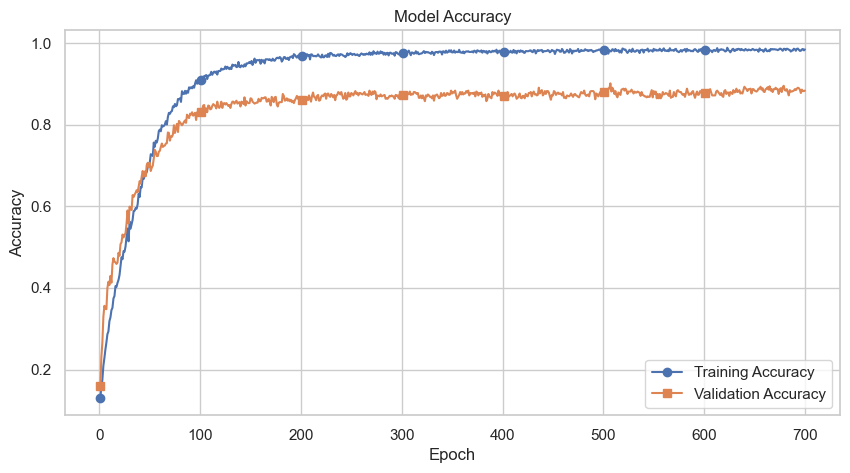

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Get the number of epochs
epochs = len(cnnhistory.history['accuracy'])
x = list(range(1, epochs + 1))

# Mark every 100 epochs
mark_every = np.arange(0, epochs, 100)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, cnnhistory.history['accuracy'], label='Training Accuracy', marker='o', markevery=mark_every)
plt.plot(x, cnnhistory.history['val_accuracy'], label='Validation Accuracy', marker='s', markevery=mark_every)

# Labels and title
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Set x-ticks every 100 epochs
plt.xticks(np.arange(0, epochs + 1, 100))

# Legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Saving the model

In [141]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [143]:
from keras.models import model_from_json
import numpy as np

# Load model structure
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# Load weights
loaded_model.load_weights("best_model.h5")
print("Loaded model from disk")

# Compile model
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fix shape of test input
x_testcnn = x_testcnn.reshape(-1, 13, 216, 1)

# Evaluate model
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print(f"{loaded_model.metrics_names[1]}: {score[1]*100:.2f}%")

Loaded model from disk
accuracy: 90.09%


## Predicting emotions on the test data

In [144]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

27/27 [==============================] - 0s 4ms/step


In [145]:
preds

array([[1.7613835e-12, 1.5120933e-15, 6.6341547e-16, ..., 2.1984729e-03,
        9.3830717e-01, 1.0367196e-05],
       [3.7533754e-09, 1.0442148e-09, 9.9998248e-01, ..., 1.2946785e-11,
        2.8479179e-12, 3.1095287e-12],
       [4.3171963e-10, 3.2382209e-17, 3.7242130e-17, ..., 3.5537414e-07,
        4.2799377e-04, 3.5137377e-06],
       ...,
       [1.0714186e-12, 1.6370251e-19, 6.7251711e-16, ..., 9.1089678e-01,
        1.3759555e-03, 1.9910494e-05],
       [1.4993592e-08, 9.9992669e-01, 2.2963957e-06, ..., 5.0728080e-08,
        6.5860720e-12, 6.2638728e-10],
       [4.2157623e-08, 2.4175969e-07, 2.4787695e-07, ..., 9.9662340e-01,
        1.1826304e-04, 5.7234865e-04]], dtype=float32)

In [146]:
preds1=preds.argmax(axis=1)

In [147]:
preds1

array([8, 2, 5, 7, 1, 4, 4, 0, 2, 8, 7, 2, 8, 4, 2, 7, 1, 5, 9, 1, 4, 2,
       1, 0, 0, 3, 5, 5, 7, 7, 7, 2, 6, 9, 8, 5, 3, 5, 3, 3, 1, 7, 9, 8,
       5, 1, 2, 9, 2, 4, 1, 9, 9, 9, 5, 2, 5, 7, 5, 9, 3, 5, 2, 6, 0, 7,
       8, 3, 4, 9, 7, 9, 1, 3, 7, 2, 4, 5, 4, 3, 5, 5, 2, 1, 0, 9, 0, 6,
       5, 5, 9, 3, 5, 9, 7, 9, 9, 3, 7, 2, 9, 7, 2, 2, 1, 5, 8, 9, 3, 8,
       4, 5, 7, 0, 5, 8, 5, 3, 7, 3, 9, 3, 7, 2, 8, 9, 6, 7, 5, 1, 3, 4,
       5, 4, 9, 5, 5, 9, 3, 1, 4, 9, 4, 0, 7, 9, 3, 1, 4, 5, 0, 2, 5, 7,
       5, 5, 2, 0, 8, 5, 7, 8, 9, 8, 6, 0, 9, 8, 2, 8, 2, 2, 9, 8, 7, 8,
       2, 9, 7, 0, 3, 9, 9, 4, 0, 9, 9, 3, 6, 6, 3, 4, 7, 3, 0, 8, 6, 0,
       0, 8, 2, 9, 8, 6, 8, 5, 9, 6, 2, 1, 2, 2, 1, 5, 0, 4, 1, 5, 4, 8,
       3, 1, 0, 8, 0, 0, 9, 2, 0, 7, 6, 1, 5, 7, 5, 8, 0, 4, 6, 7, 9, 1,
       0, 5, 8, 0, 7, 8, 1, 1, 0, 9, 1, 7, 6, 4, 8, 3, 3, 5, 5, 0, 1, 7,
       9, 9, 1, 5, 0, 8, 0, 6, 3, 0, 1, 5, 9, 3, 3, 5, 0, 1, 5, 5, 8, 0,
       8, 7, 5, 9, 5, 7, 8, 3, 5, 4, 3, 7, 0, 7, 9,

In [148]:
abc = preds1.astype(int).flatten()

In [149]:
predictions = (lb.inverse_transform((abc)))

In [150]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_happy
1,female_fearful
2,male_angry
3,male_fearful
4,female_calm
5,female_sad
6,female_sad
7,female_angry
8,female_fearful
9,male_happy


In [151]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [152]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_happy
1,female_fearful
2,male_angry
3,male_fearful
4,female_calm
5,female_sad
6,female_sad
7,female_angry
8,female_fearful
9,male_happy


In [153]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [154]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,female_fearful,female_fearful
172,male_sad,male_sad
173,male_sad,male_happy
174,male_fearful,male_fearful
175,male_happy,male_happy
176,female_fearful,female_fearful
177,male_sad,male_sad
178,male_fearful,male_fearful
179,female_angry,female_angry


In [155]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,69
female_calm,84
female_fearful,77
female_happy,76
female_sad,72
male_angry,110
male_calm,73
male_fearful,93
male_happy,97


In [156]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,73
female_calm,76
female_fearful,78
female_happy,73
female_sad,75
male_angry,115
male_calm,69
male_fearful,89
male_happy,101


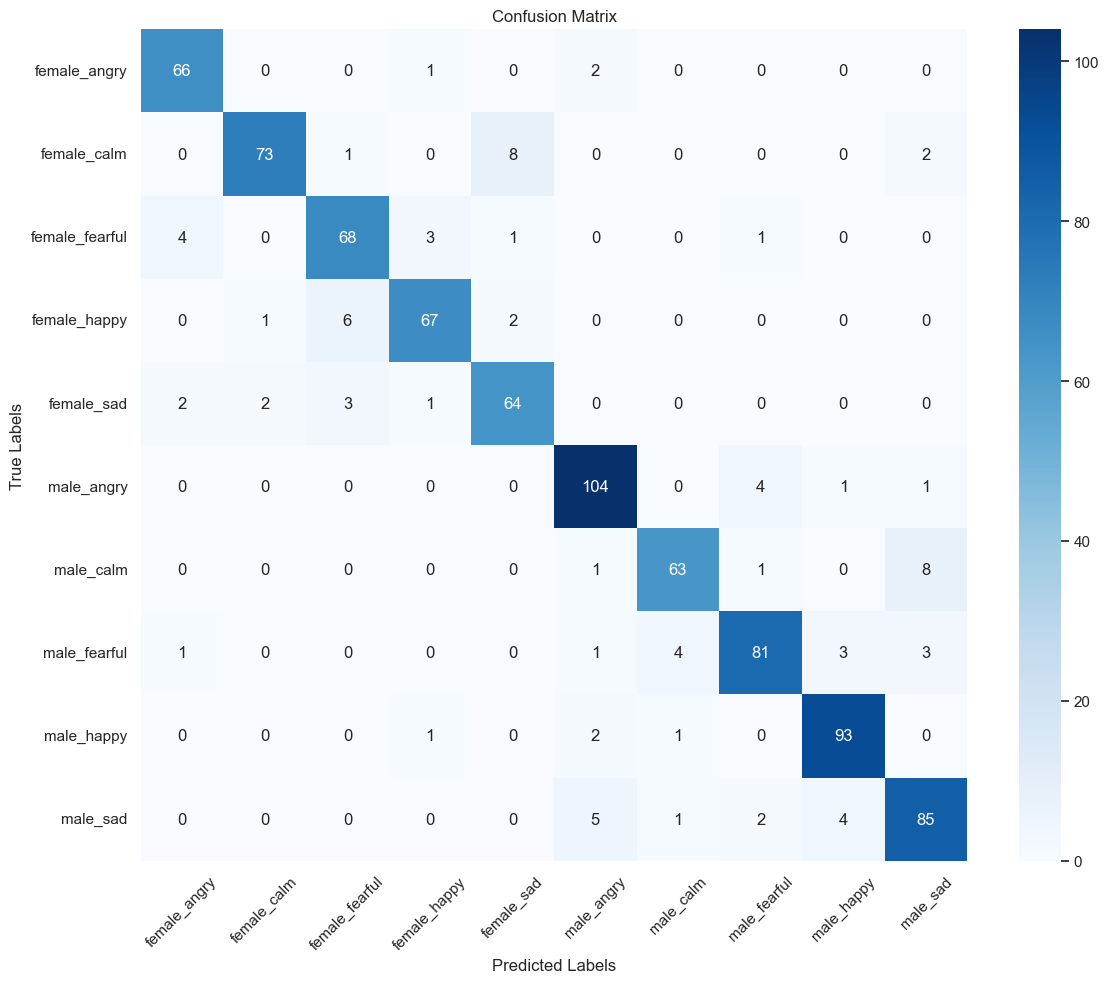

In [161]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true and predicted labels
y_true = finaldf['actualvalues']
y_pred = finaldf['predictedvalues']

# Define class label order
labels = sorted(finaldf['actualvalues'].unique())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Save the plot before showing it
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)  # Save to file
plt.show()

In [157]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [162]:
data, sampling_rate = librosa.load('output10.wav')

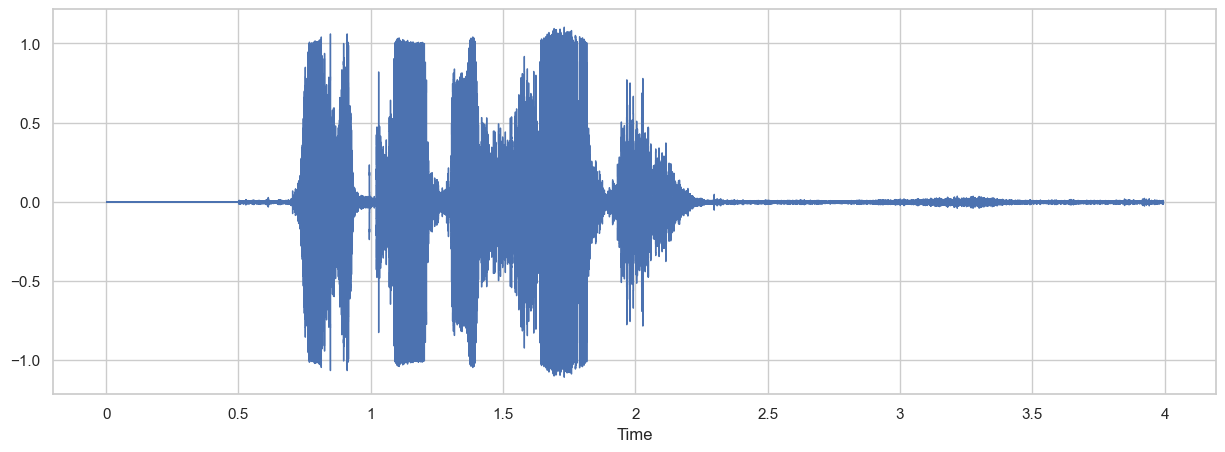

In [163]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [164]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [165]:
livedf2= pd.DataFrame(data=livedf2)

In [166]:
livedf2 = livedf2.stack().to_frame().T

In [167]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-21.58255,-23.610638,-22.522213,-21.712259,-22.26428,-20.707909,-21.72644,-21.76865,-24.302736,-22.250633,...,-24.273817,-24.63994,-24.929155,-24.439188,-25.210173,-24.740648,-22.311916,-22.579805,-22.387119,-23.966024


In [168]:
twodim= np.expand_dims(livedf2, axis=2)

In [169]:
import librosa
import numpy as np

# load your audio sample (e.g. wav file)
data, sr = librosa.load('output10.wav', sr=22050)

# extract MFCC features (make sure n_mfcc=13 matches model training)
mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)

print(mfccs.shape)  # should be (13, something close to 216)

# If necessary, pad or trim mfccs to have 216 frames
import numpy as np
max_pad_len = 216
if mfccs.shape[1] < max_pad_len:
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0,0),(0,pad_width)), mode='constant')
else:
    mfccs = mfccs[:, :max_pad_len]

print(mfccs.shape)  # should be (13, 216)

# Add batch and channel dimensions
input_for_model = mfccs.reshape(1, 13, 216, 1)  # batch=1, height=13, width=216, channels=1

# Now predict
livepreds = loaded_model.predict(input_for_model, batch_size=32, verbose=1)
print(livepreds)

(13, 173)
(13, 216)
1/1 [==============================] - 0s 85ms/step
[[3.3334084e-03 2.0932427e-04 7.1559474e-04 1.0872221e-03 1.1809622e-03
  8.0218899e-01 7.5242911e-05 1.8569410e-01 8.4334228e-05 5.4308488e-03]]


In [170]:
livepreds

array([[3.3334084e-03, 2.0932427e-04, 7.1559474e-04, 1.0872221e-03,
        1.1809622e-03, 8.0218899e-01, 7.5242911e-05, 1.8569410e-01,
        8.4334228e-05, 5.4308488e-03]], dtype=float32)

In [171]:
livepreds1=livepreds.argmax(axis=1)

In [172]:
liveabc = livepreds1.astype(int).flatten()

In [173]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype='<U14')